# Improved GAN for Tabular Data Synthesis

## Key Improvements:
1. Quantile Transform (replaces VGM)
2. Autoregressive Generator
3. Straight-Through Estimator for hard thresholds
4. Moment matching loss
5. Learned thresholds for zero/peak inflation
6. Per-feature discriminators
7. Post-processing calibration
8. Two-stage training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, QuantileTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## 1. Data Loading

In [3]:
data, meta = arff.loadarff('adult.arff')
df = pd.DataFrame(data)

for col in df.select_dtypes([object]).columns:
    df[col] = df[col].str.decode('utf-8')

print(f"Dataset shape: {df.shape}")
print(f"Target distribution:\n{df['income'].value_counts(normalize=True)}")

Dataset shape: (32561, 15)
Target distribution:
income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64


## 2. Improved Preprocessor with Quantile Transform

In [4]:
CONTINUOUS_COLS = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
CATEGORICAL_COLS = ['workclass', 'education', 'marital-status', 
                    'occupation', 'relationship', 'race', 'sex', 'native-country']
TARGET_COL = 'income'

# Features with special distributions
ZERO_INFLATED_COLS = ['capital-gain', 'capital-loss']  # ~90% zeros
PEAK_INFLATED_COLS = {'hours-per-week': 40}  # ~47% at value 40

In [5]:
class ImprovedPreprocessor:
    """Preprocessor with Quantile Transform and explicit inflation handling."""
    
    def __init__(self, rare_threshold=0.01, n_quantiles=1000):
        self.rare_threshold = rare_threshold
        self.n_quantiles = n_quantiles
        self.fitted = False
        
        # Will be set during fit
        self.quantile_transformers = {}
        self.categorical_encoders = {}
        self.categorical_dims = {}
        self.label_encoder = LabelEncoder()
        
        # Track inflation statistics
        self.zero_proportions = {}
        self.peak_proportions = {}
        self.peak_values = {}
        
    def fit(self, df, continuous_cols, categorical_cols, y_train,
            zero_inflated_cols, peak_inflated_cols):
        """Fit preprocessor on training data."""
        self.continuous_cols = continuous_cols
        self.categorical_cols = categorical_cols
        # y_train passed directly for label encoding
        self.zero_inflated_cols = zero_inflated_cols
        self.peak_inflated_cols = peak_inflated_cols
        
        # Fit quantile transformers for continuous features
        for col in continuous_cols:
            values = df[col].values.reshape(-1, 1)
            
            if col in zero_inflated_cols:
                # Track zero proportion
                self.zero_proportions[col] = (df[col] == 0).mean()
                # Fit only on non-zero values
                non_zero_mask = df[col] != 0
                if non_zero_mask.sum() > 0:
                    qt = QuantileTransformer(n_quantiles=min(self.n_quantiles, non_zero_mask.sum()),
                                            output_distribution='uniform', random_state=42)
                    qt.fit(df.loc[non_zero_mask, col].values.reshape(-1, 1))
                    self.quantile_transformers[col] = qt
            elif col in peak_inflated_cols:
                peak_val = peak_inflated_cols[col]
                self.peak_values[col] = peak_val
                self.peak_proportions[col] = (df[col] == peak_val).mean()
                # Fit only on non-peak values
                non_peak_mask = df[col] != peak_val
                if non_peak_mask.sum() > 0:
                    qt = QuantileTransformer(n_quantiles=min(self.n_quantiles, non_peak_mask.sum()),
                                            output_distribution='uniform', random_state=42)
                    qt.fit(df.loc[non_peak_mask, col].values.reshape(-1, 1))
                    self.quantile_transformers[col] = qt
            else:
                qt = QuantileTransformer(n_quantiles=self.n_quantiles,
                                        output_distribution='uniform', random_state=42)
                qt.fit(values)
                self.quantile_transformers[col] = qt
        
        # Fit categorical encoders with rare category grouping
        for col in categorical_cols:
            value_counts = df[col].value_counts(normalize=True)
            rare_cats = value_counts[value_counts < self.rare_threshold].index.tolist()
            
            # Create mapping
            mapping = {}
            idx = 0
            for cat in value_counts.index:
                if cat in rare_cats:
                    mapping[cat] = 'Other'
                else:
                    mapping[cat] = cat
            
            # Get unique categories after mapping
            unique_cats = sorted(set(mapping.values()))
            cat_to_idx = {cat: i for i, cat in enumerate(unique_cats)}
            
            self.categorical_encoders[col] = {'mapping': mapping, 'cat_to_idx': cat_to_idx}
            self.categorical_dims[col] = len(unique_cats)
        
        # Fit label encoder
        self.label_encoder.fit(y_train)
        self.num_classes = len(self.label_encoder.classes_)
        
        self.fitted = True
        return self
    
    def transform(self, df):
        """Transform data to model input format."""
        if not self.fitted:
            raise ValueError("Preprocessor must be fitted first")
        
        result_parts = []
        
        # Transform continuous features
        for col in self.continuous_cols:
            values = df[col].values
            
            if col in self.zero_inflated_cols:
                # Output: [is_zero, transformed_value]
                is_zero = (values == 0).astype(np.float32).reshape(-1, 1)
                transformed = np.zeros((len(values), 1), dtype=np.float32)
                non_zero_mask = values != 0
                if non_zero_mask.sum() > 0:
                    transformed[non_zero_mask] = self.quantile_transformers[col].transform(
                        values[non_zero_mask].reshape(-1, 1)
                    )
                result_parts.extend([is_zero, transformed])
                
            elif col in self.peak_inflated_cols:
                peak_val = self.peak_values[col]
                is_peak = (values == peak_val).astype(np.float32).reshape(-1, 1)
                transformed = np.zeros((len(values), 1), dtype=np.float32)
                non_peak_mask = values != peak_val
                if non_peak_mask.sum() > 0:
                    transformed[non_peak_mask] = self.quantile_transformers[col].transform(
                        values[non_peak_mask].reshape(-1, 1)
                    )
                result_parts.extend([is_peak, transformed])
                
            else:
                transformed = self.quantile_transformers[col].transform(
                    values.reshape(-1, 1)
                )
                result_parts.append(transformed)
        
        # Transform categorical features (one-hot)
        for col in self.categorical_cols:
            encoder = self.categorical_encoders[col]
            mapped = df[col].map(encoder['mapping']).fillna('Other')
            indices = mapped.map(encoder['cat_to_idx']).values
            one_hot = np.zeros((len(df), self.categorical_dims[col]), dtype=np.float32)
            one_hot[np.arange(len(df)), indices.astype(int)] = 1
            result_parts.append(one_hot)
        
        return np.hstack(result_parts)
    
    def transform_labels(self, labels):
        """Transform target labels."""
        return self.label_encoder.transform(labels)
    
    def inverse_transform(self, data):
        """Inverse transform generated data back to original format."""
        result = {}
        pos = 0
        
        # Inverse transform continuous features
        for col in self.continuous_cols:
            if col in self.zero_inflated_cols:
                is_zero = data[:, pos]
                transformed = data[:, pos + 1]
                pos += 2
                
                # Inverse transform non-zero values
                values = self.quantile_transformers[col].inverse_transform(
                    transformed.reshape(-1, 1)
                ).flatten()
                values[is_zero > 0.5] = 0
                result[col] = values
                
            elif col in self.peak_inflated_cols:
                is_peak = data[:, pos]
                transformed = data[:, pos + 1]
                pos += 2
                
                values = self.quantile_transformers[col].inverse_transform(
                    transformed.reshape(-1, 1)
                ).flatten()
                values[is_peak > 0.5] = self.peak_values[col]
                result[col] = values
                
            else:
                transformed = data[:, pos]
                pos += 1
                values = self.quantile_transformers[col].inverse_transform(
                    transformed.reshape(-1, 1)
                ).flatten()
                result[col] = values
        
        # Inverse transform categorical features
        for col in self.categorical_cols:
            dim = self.categorical_dims[col]
            one_hot = data[:, pos:pos + dim]
            pos += dim
            
            indices = np.argmax(one_hot, axis=1)
            idx_to_cat = {v: k for k, v in self.categorical_encoders[col]['cat_to_idx'].items()}
            result[col] = [idx_to_cat[i] for i in indices]
        
        return pd.DataFrame(result)
    
    def get_feature_structure(self):
        """Get structure information for generator/discriminator."""
        structure = []
        
        for col in self.continuous_cols:
            if col in self.zero_inflated_cols:
                structure.append(('zero_inflated', col, 2, self.zero_proportions[col]))
            elif col in self.peak_inflated_cols:
                structure.append(('peak_inflated', col, 2, self.peak_proportions[col]))
            else:
                structure.append(('continuous', col, 1, None))
        
        for col in self.categorical_cols:
            structure.append(('categorical', col, self.categorical_dims[col], None))
        
        return structure
    
    def get_output_dim(self):
        """Get total output dimension."""
        dim = 0
        for col in self.continuous_cols:
            if col in self.zero_inflated_cols or col in self.peak_inflated_cols:
                dim += 2
            else:
                dim += 1
        for col in self.categorical_cols:
            dim += self.categorical_dims[col]
        return dim

## 3. Generator Architecture

Features:
- Autoregressive generation (features conditioned on previous)
- Straight-Through Estimator for hard thresholds
- Learned thresholds for zero/peak inflation

In [6]:
class StraightThroughEstimator(torch.autograd.Function):
    """Hard threshold in forward, soft gradient in backward."""
    
    @staticmethod
    def forward(ctx, prob, threshold):
        return (prob > threshold).float()
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output, None  # Pass gradient through


def straight_through_threshold(prob, threshold=0.5):
    """Apply hard threshold with straight-through gradient."""
    return StraightThroughEstimator.apply(prob, threshold)


class LearnedThreshold(nn.Module):
    """Learnable threshold parameter for inflation detection."""
    
    def __init__(self, init_logit=0.0):
        super().__init__()
        self.logit = nn.Parameter(torch.tensor(init_logit))
    
    @property
    def threshold(self):
        return torch.sigmoid(self.logit)
    
    def forward(self, prob):
        """Apply learned threshold with straight-through estimator."""
        threshold = self.threshold
        hard = (prob > threshold).float()
        # Straight-through: hard in forward, soft gradient in backward
        return hard - prob.detach() + prob


class GumbelSoftmax(nn.Module):
    """Gumbel-Softmax with straight-through estimator."""
    
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature
    
    def forward(self, logits, hard=True):
        if self.training:
            # Sample from Gumbel-Softmax
            gumbels = -torch.log(-torch.log(torch.rand_like(logits) + 1e-10) + 1e-10)
            y_soft = F.softmax((logits + gumbels) / self.temperature, dim=-1)
            
            if hard:
                # Straight-through
                idx = y_soft.argmax(dim=-1, keepdim=True)
                y_hard = torch.zeros_like(logits).scatter_(-1, idx, 1.0)
                return y_hard - y_soft.detach() + y_soft
            return y_soft
        else:
            # Inference: use argmax
            idx = logits.argmax(dim=-1, keepdim=True)
            return torch.zeros_like(logits).scatter_(-1, idx, 1.0)

In [7]:
class ImprovedGenerator(nn.Module):
    """Generator with autoregressive structure and learned thresholds."""
    
    def __init__(self, latent_dim, feature_structure, hidden_dim=256, temperature=0.2):
        super().__init__()
        self.latent_dim = latent_dim
        self.feature_structure = feature_structure
        self.hidden_dim = hidden_dim
        self.temperature = temperature
        
        # Shared backbone
        self.backbone = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
        )
        
        # Feature-specific heads with autoregressive conditioning
        self.feature_heads = nn.ModuleList()
        self.learned_thresholds = nn.ModuleDict()
        self.gumbel_softmax = GumbelSoftmax(temperature)
        
        cumulative_dim = hidden_dim * 2  # Start with backbone output
        
        for feat_type, feat_name, feat_dim, proportion in feature_structure:
            if feat_type == 'zero_inflated':
                # Output: [is_zero_logit, value]
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, 2)
                )
                # Initialize threshold based on real proportion
                init_logit = np.log(proportion / (1 - proportion + 1e-8))
                self.learned_thresholds[feat_name] = LearnedThreshold(init_logit)
                cumulative_dim += 2
                
            elif feat_type == 'peak_inflated':
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, 2)
                )
                init_logit = np.log(proportion / (1 - proportion + 1e-8))
                self.learned_thresholds[feat_name] = LearnedThreshold(init_logit)
                cumulative_dim += 2
                
            elif feat_type == 'continuous':
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, 1)
                )
                cumulative_dim += 1
                
            else:  # categorical
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, feat_dim)
                )
                cumulative_dim += feat_dim
            
            self.feature_heads.append(head)
    
    def forward(self, z):
        batch_size = z.shape[0]
        
        # Get backbone features
        h = self.backbone(z)
        
        outputs = []
        current_context = h
        
        for i, (feat_type, feat_name, feat_dim, _) in enumerate(self.feature_structure):
            head = self.feature_heads[i]
            raw_output = head(current_context)
            
            if feat_type == 'zero_inflated':
                is_special_logit = raw_output[:, 0:1]
                value_raw = raw_output[:, 1:2]
                
                is_special_prob = torch.sigmoid(is_special_logit)
                is_special = self.learned_thresholds[feat_name](is_special_prob)
                value = torch.sigmoid(value_raw)  # Value in [0, 1]
                
                output = torch.cat([is_special, value], dim=1)
                
            elif feat_type == 'peak_inflated':
                is_special_logit = raw_output[:, 0:1]
                value_raw = raw_output[:, 1:2]
                
                is_special_prob = torch.sigmoid(is_special_logit)
                is_special = self.learned_thresholds[feat_name](is_special_prob)
                value = torch.sigmoid(value_raw)
                
                output = torch.cat([is_special, value], dim=1)
                
            elif feat_type == 'continuous':
                output = torch.sigmoid(raw_output)  # Value in [0, 1]
                
            else:  # categorical
                output = self.gumbel_softmax(raw_output, hard=True)
            
            outputs.append(output)
            
            # Autoregressive: condition next head on this output
            current_context = torch.cat([current_context, output], dim=1)
        
        return torch.cat(outputs, dim=1)


class ConditionalImprovedGenerator(nn.Module):
    """Conditional version of ImprovedGenerator."""
    
    def __init__(self, latent_dim, num_classes, feature_structure, hidden_dim=256, temperature=0.2):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.feature_structure = feature_structure
        self.hidden_dim = hidden_dim
        
        # Class embedding
        self.class_embed = nn.Embedding(num_classes, hidden_dim // 4)
        
        # Shared backbone (takes z + class embedding)
        input_dim = latent_dim + hidden_dim // 4
        self.backbone = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.LayerNorm(hidden_dim * 2),
            nn.LeakyReLU(0.2),
        )
        
        # Feature-specific heads
        self.feature_heads = nn.ModuleList()
        self.learned_thresholds = nn.ModuleDict()
        self.gumbel_softmax = GumbelSoftmax(temperature)
        
        cumulative_dim = hidden_dim * 2
        
        for feat_type, feat_name, feat_dim, proportion in feature_structure:
            if feat_type in ['zero_inflated', 'peak_inflated']:
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, 2)
                )
                init_logit = np.log(proportion / (1 - proportion + 1e-8)) if proportion else 0.0
                self.learned_thresholds[feat_name] = LearnedThreshold(init_logit)
                cumulative_dim += 2
            elif feat_type == 'continuous':
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, 1)
                )
                cumulative_dim += 1
            else:
                head = nn.Sequential(
                    nn.Linear(cumulative_dim, hidden_dim),
                    nn.LeakyReLU(0.2),
                    nn.Linear(hidden_dim, feat_dim)
                )
                cumulative_dim += feat_dim
            
            self.feature_heads.append(head)
    
    def forward(self, z, labels):
        class_emb = self.class_embed(labels)
        z_cond = torch.cat([z, class_emb], dim=1)
        
        h = self.backbone(z_cond)
        
        outputs = []
        current_context = h
        
        for i, (feat_type, feat_name, feat_dim, _) in enumerate(self.feature_structure):
            head = self.feature_heads[i]
            raw_output = head(current_context)
            
            if feat_type in ['zero_inflated', 'peak_inflated']:
                is_special_prob = torch.sigmoid(raw_output[:, 0:1])
                is_special = self.learned_thresholds[feat_name](is_special_prob)
                value = torch.sigmoid(raw_output[:, 1:2])
                output = torch.cat([is_special, value], dim=1)
            elif feat_type == 'continuous':
                output = torch.sigmoid(raw_output)
            else:
                output = self.gumbel_softmax(raw_output, hard=True)
            
            outputs.append(output)
            current_context = torch.cat([current_context, output], dim=1)
        
        return torch.cat(outputs, dim=1)

## 4. Discriminator Architecture

Features:
- Main discriminator with spectral normalization
- Per-feature discriminators for problematic columns
- Minibatch discrimination

In [8]:
class MinibatchDiscrimination(nn.Module):
    """Minibatch discrimination layer to prevent mode collapse."""
    
    def __init__(self, input_dim, output_dim, kernel_dim):
        super().__init__()
        self.T = nn.Parameter(torch.randn(input_dim, output_dim, kernel_dim) * 0.1)
    
    def forward(self, x):
        # x: (batch, input_dim)
        M = torch.einsum('bi,ijk->bjk', x, self.T)  # (batch, output_dim, kernel_dim)
        
        # Compute L1 distance between all pairs
        diffs = M.unsqueeze(0) - M.unsqueeze(1)  # (batch, batch, output_dim, kernel_dim)
        abs_diffs = torch.abs(diffs).sum(dim=3)  # (batch, batch, output_dim)
        exp_diffs = torch.exp(-abs_diffs)  # (batch, batch, output_dim)
        
        # Sum over all other samples (excluding self)
        o = exp_diffs.sum(dim=0) - 1  # (batch, output_dim)
        return o


class PerFeatureDiscriminator(nn.Module):
    """Discriminator for a single continuous feature's distribution."""
    
    def __init__(self, n_bins=50, hidden_dim=64):
        super().__init__()
        self.n_bins = n_bins
        self.hidden_dim = hidden_dim
        
        self.net = nn.Sequential(
            nn.Linear(n_bins, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1)
        )
    
    def compute_histogram(self, x, soft=True):
        """Compute differentiable histogram."""
        batch_size = x.shape[0]
        
        # Bin centers from 0 to 1
        bin_centers = torch.linspace(0, 1, self.n_bins, device=x.device)
        bin_width = 1.0 / self.n_bins
        
        if soft:
            # Soft histogram with Gaussian kernels
            sigma = bin_width
            x_expanded = x.unsqueeze(1)  # (batch, 1)
            centers_expanded = bin_centers.unsqueeze(0)  # (1, n_bins)
            
            # Gaussian weights
            weights = torch.exp(-((x_expanded - centers_expanded) ** 2) / (2 * sigma ** 2))
            hist = weights.mean(dim=0)  # Average over batch
        else:
            # Hard histogram (not differentiable)
            hist = torch.histc(x, bins=self.n_bins, min=0, max=1)
            hist = hist / hist.sum()
        
        return hist
    
    def forward(self, x):
        """x: (batch_size,) single feature values in [0, 1]."""
        hist = self.compute_histogram(x, soft=True)
        return self.net(hist.unsqueeze(0)).squeeze()


class ImprovedDiscriminator(nn.Module):
    """Main discriminator with spectral norm and minibatch discrimination."""
    
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
        )
        
        self.mb_disc = MinibatchDiscrimination(hidden_dim, 32, 3)
        
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(hidden_dim + 32, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x):
        feat = self.features(x)
        mb_out = self.mb_disc(feat)
        combined = torch.cat([feat, mb_out], dim=1)
        return self.classifier(combined)


class ConditionalImprovedDiscriminator(nn.Module):
    """Conditional discriminator with class embedding."""
    
    def __init__(self, input_dim, num_classes, hidden_dim=256, dropout=0.3):
        super().__init__()
        
        self.class_embed = nn.Embedding(num_classes, hidden_dim // 4)
        total_input = input_dim + hidden_dim // 4
        
        self.features = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(total_input, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
        )
        
        self.mb_disc = MinibatchDiscrimination(hidden_dim, 32, 3)
        
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(hidden_dim + 32, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, x, labels):
        class_emb = self.class_embed(labels)
        x_cond = torch.cat([x, class_emb], dim=1)
        feat = self.features(x_cond)
        mb_out = self.mb_disc(feat)
        combined = torch.cat([feat, mb_out], dim=1)
        return self.classifier(combined)

## 5. Loss Functions

- WGAN-GP loss with gradient penalty
- Moment matching loss (mean, variance, skewness)
- Correlation loss
- Special value proportion loss
- Per-feature discriminator loss

In [9]:
def gradient_penalty(discriminator, real_data, fake_data, device, labels=None):
    """Compute gradient penalty for WGAN-GP."""
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=device).expand_as(real_data)
    
    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)
    
    if labels is not None:
        d_interpolated = discriminator(interpolated, labels)
    else:
        d_interpolated = discriminator(interpolated)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()
    
    return penalty


def moment_matching_loss(real, fake, feature_structure):
    """Match mean, variance, and skewness per feature."""
    loss = torch.tensor(0.0, device=real.device)
    pos = 0
    n_features = 0
    
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # For inflated features, match the value distribution (column 1)
            r = real[:, pos + 1]
            f = fake[:, pos + 1]
            pos += 2
        elif feat_type == 'continuous':
            r = real[:, pos]
            f = fake[:, pos]
            pos += 1
        else:
            # Skip categorical
            pos += feat_dim
            continue
        
        # Mean
        loss = loss + ((r.mean() - f.mean()) ** 2)
        
        # Variance
        r_var = r.var() + 1e-8
        f_var = f.var() + 1e-8
        loss = loss + ((r_var - f_var) ** 2)
        
        # Skewness (3rd standardized moment)
        r_std = r.std() + 1e-8
        f_std = f.std() + 1e-8
        r_skew = ((r - r.mean()) ** 3).mean() / (r_std ** 3)
        f_skew = ((f - f.mean()) ** 3).mean() / (f_std ** 3)
        loss = loss + ((r_skew - f_skew) ** 2)
        
        n_features += 1
    
    return loss / max(n_features, 1)


def correlation_loss(real, fake, feature_structure):
    """Loss to match correlation structure between features."""
    # Get indices of continuous/inflated features (values only)
    cont_indices = []
    pos = 0
    
    for feat_type, _, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            cont_indices.append(pos + 1)  # Value column
            pos += 2
        elif feat_type == 'continuous':
            cont_indices.append(pos)
            pos += 1
        else:
            pos += feat_dim
    
    if len(cont_indices) < 2:
        return torch.tensor(0.0, device=real.device)
    
    real_cont = real[:, cont_indices]
    fake_cont = fake[:, cont_indices]
    
    # Compute correlation matrices
    def compute_corr(x):
        x_centered = x - x.mean(dim=0, keepdim=True)
        x_std = x.std(dim=0, keepdim=True) + 1e-8
        x_normalized = x_centered / x_std
        corr = torch.mm(x_normalized.t(), x_normalized) / (x.shape[0] - 1)
        return corr
    
    real_corr = compute_corr(real_cont)
    fake_corr = compute_corr(fake_cont)
    
    # Frobenius norm of difference
    return ((real_corr - fake_corr) ** 2).mean()


def special_proportion_loss(real, fake, feature_structure):
    """Loss to match proportion of special values (zeros, peaks)."""
    loss = torch.tensor(0.0, device=real.device)
    count = 0
    pos = 0
    
    for feat_type, _, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # Column 0 is the is_special indicator
            real_is_special = real[:, pos]
            fake_is_special = fake[:, pos]
            
            real_prop = real_is_special.mean()
            fake_prop = fake_is_special.mean()
            
            loss = loss + ((real_prop - fake_prop) ** 2)
            count += 1
            pos += 2
        elif feat_type == 'continuous':
            pos += 1
        else:
            pos += feat_dim
    
    return loss / max(count, 1)


def per_feature_disc_loss(per_feat_discs, real, fake, feature_structure, feature_indices):
    """Compute per-feature discriminator losses."""
    loss = torch.tensor(0.0, device=real.device)
    
    for feat_name, disc in per_feat_discs.items():
        idx = feature_indices[feat_name]
        
        # Get the value column for this feature
        real_feat = real[:, idx]
        fake_feat = fake[:, idx]
        
        # Discriminator should output high for real, low for fake
        d_real = disc(real_feat)
        d_fake = disc(fake_feat)
        
        # WGAN-style loss for this feature
        loss = loss + (d_fake - d_real)
    
    return loss / max(len(per_feat_discs), 1)

## 6. Post-Processing Calibration

Calibrate synthetic data to exactly match real data proportions for special values.

In [10]:
def calibrate_special_values(synthetic_data, real_data, feature_structure):
    """Post-process synthetic data to match real proportions exactly."""
    calibrated = synthetic_data.copy()
    pos = 0
    
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # Get real proportion of special values
            real_special_prop = (real_data[:, pos] > 0.5).mean()
            
            # Get synthetic special indicators
            synth_special = calibrated[:, pos]
            
            # Sort by "specialness" probability
            sorted_indices = np.argsort(-synth_special)  # Descending
            
            # Set top real_special_prop fraction to special
            n_special = int(real_special_prop * len(synthetic_data))
            
            # Create new special indicator
            new_special = np.zeros(len(synthetic_data))
            new_special[sorted_indices[:n_special]] = 1.0
            
            calibrated[:, pos] = new_special
            
            # IMPORTANT: Set value column to 0 for special values (zeros/peaks)
            # For zero-inflated: value should be 0 when is_zero=1
            # For peak-inflated: value should be 0 (representing the peak in transformed space)
            special_mask = new_special > 0.5
            calibrated[special_mask, pos + 1] = 0.0
            
            pos += 2
            
        elif feat_type == 'continuous':
            pos += 1
        else:
            pos += feat_dim
    
    return calibrated


def calibrate_continuous_values(synthetic_data, real_data, feature_structure):
    """Match quantiles of continuous values to real data."""
    calibrated = synthetic_data.copy()
    pos = 0
    
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # Get non-special values only
            real_is_special = real_data[:, pos] > 0.5
            synth_is_special = calibrated[:, pos] > 0.5
            
            real_values = real_data[~real_is_special, pos + 1]
            synth_values = calibrated[~synth_is_special, pos + 1]
            
            if len(real_values) > 0 and len(synth_values) > 0:
                # Sort synthetic values and assign real quantiles
                synth_sorted_idx = np.argsort(synth_values)
                real_sorted = np.sort(real_values)
                
                # Map synthetic to real quantiles
                n_synth = len(synth_values)
                n_real = len(real_values)
                
                # Get the indices in real_sorted that correspond to synthetic quantiles
                real_indices = (np.arange(n_synth) * (n_real - 1) / max(n_synth - 1, 1)).astype(int)
                new_values = real_sorted[real_indices]
                
                # Put back in original order
                non_special_idx = np.where(~synth_is_special)[0]
                calibrated[non_special_idx[synth_sorted_idx], pos + 1] = new_values
            
            pos += 2
        elif feat_type == 'continuous':
            # For regular continuous, also do quantile matching
            real_values = real_data[:, pos]
            synth_values = calibrated[:, pos]
            
            synth_sorted_idx = np.argsort(synth_values)
            real_sorted = np.sort(real_values)
            
            n_synth = len(synth_values)
            n_real = len(real_values)
            
            real_indices = (np.arange(n_synth) * (n_real - 1) / max(n_synth - 1, 1)).astype(int)
            new_values = real_sorted[real_indices]
            
            calibrated[synth_sorted_idx, pos] = new_values
            pos += 1
        else:
            pos += feat_dim
    
    return calibrated


def calibrate_categorical_proportions(synthetic_data, real_data, feature_structure):
    """Calibrate categorical features to match real distribution."""
    calibrated = synthetic_data.copy()
    pos = 0
    
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            pos += 2
        elif feat_type == 'continuous':
            pos += 1
        else:
            # Categorical feature
            real_cats = real_data[:, pos:pos + feat_dim]
            synth_cats = calibrated[:, pos:pos + feat_dim]
            
            # Get real category proportions
            real_proportions = real_cats.mean(axis=0)
            
            # Get synthetic soft probabilities (before argmax)
            synth_probs = synth_cats.sum(axis=1, keepdims=True)  # Should be 1
            
            # For each sample, resample category based on real proportions
            # Only for samples with low confidence
            confidence = synth_cats.max(axis=1)
            low_conf_mask = confidence < 0.9
            
            if low_conf_mask.sum() > 0:
                # Resample these according to real proportions
                n_resample = low_conf_mask.sum()
                new_cats = np.zeros((n_resample, feat_dim))
                sampled_indices = np.random.choice(
                    feat_dim, size=n_resample, p=real_proportions / real_proportions.sum()
                )
                new_cats[np.arange(n_resample), sampled_indices] = 1.0
                calibrated[low_conf_mask, pos:pos + feat_dim] = new_cats
            
            pos += feat_dim
    
    return calibrated


def full_calibration(synthetic_data, real_data, feature_structure):
    """Apply all calibration steps."""
    calibrated = calibrate_special_values(synthetic_data, real_data, feature_structure)
    calibrated = calibrate_continuous_values(calibrated, real_data, feature_structure)
    calibrated = calibrate_categorical_proportions(calibrated, real_data, feature_structure)
    return calibrated

## 7. Two-Stage Training

Stage 1: Train generator to match marginal distributions (per-feature)
Stage 2: Fine-tune with full adversarial + correlation matching

In [11]:
def train_improved_gan(X_train, preprocessor, 
                        latent_dim=128, hidden_dim=256,
                        batch_size=256, 
                        stage1_epochs=100, stage2_epochs=300,
                        lr_g=0.0002, lr_d=0.0001,
                        n_critic=5, lambda_gp=10,
                        lambda_moment=1.0, lambda_corr=0.5, lambda_special=2.0,
                        lambda_per_feat=0.5,
                        temperature=0.2, dropout=0.3,
                        instance_noise=0.1, seed=42):
    """
    Two-stage training for improved GAN.
    
    Stage 1: Match marginal distributions using moment matching + per-feature discriminators
    Stage 2: Full adversarial training with correlation matching
    """
    set_seed(seed)
    
    feature_structure = preprocessor.get_feature_structure()
    data_dim = preprocessor.get_output_dim()
    
    # Create generator
    generator = ImprovedGenerator(
        latent_dim=latent_dim,
        feature_structure=feature_structure,
        hidden_dim=hidden_dim,
        temperature=temperature
    ).to(device)
    
    # Create main discriminator
    discriminator = ImprovedDiscriminator(
        input_dim=data_dim,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    
    # Create per-feature discriminators for problematic features
    per_feat_discs = {}
    feature_indices = {}
    pos = 0
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            per_feat_discs[feat_name] = PerFeatureDiscriminator(n_bins=50).to(device)
            feature_indices[feat_name] = pos + 1  # Value column
            pos += 2
        elif feat_type == 'continuous':
            pos += 1
        else:
            pos += feat_dim
    
    # Optimizers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    
    # Per-feature discriminator optimizers
    per_feat_optimizers = {
        name: torch.optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.9))
        for name, disc in per_feat_discs.items()
    }
    
    # Data loader
    dataset = TensorDataset(torch.FloatTensor(X_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    
    total_epochs = stage1_epochs + stage2_epochs
    
    print(f"Stage 1: Marginal matching ({stage1_epochs} epochs)")
    print(f"Stage 2: Full adversarial ({stage2_epochs} epochs)")
    print(f"Data dimension: {data_dim}")
    print(f"Per-feature discriminators: {list(per_feat_discs.keys())}")
    
    for epoch in tqdm(range(total_epochs), desc="Training Improved GAN"):
        is_stage1 = epoch < stage1_epochs
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        
        for batch_idx, (real_data,) in enumerate(dataloader):
            real_data = real_data.to(device)
            batch_size_actual = real_data.size(0)
            
            # Generate fake data
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z)
            
            if is_stage1:
                # ============ STAGE 1: Marginal Matching ============
                # Train per-feature discriminators
                for name, disc in per_feat_discs.items():
                    optimizer = per_feat_optimizers[name]
                    optimizer.zero_grad()
                    
                    idx = feature_indices[name]
                    d_real = disc(real_data[:, idx])
                    d_fake = disc(fake_data[:, idx].detach())
                    
                    d_loss_feat = d_fake - d_real
                    d_loss_feat.backward()
                    optimizer.step()
                
                # Train generator with marginal losses
                if (batch_idx + 1) % n_critic == 0:
                    optimizer_g.zero_grad()
                    
                    fake_data = generator(z)
                    
                    # Moment matching loss
                    moment_loss = moment_matching_loss(real_data, fake_data, feature_structure)
                    
                    # Special proportion loss
                    special_loss = special_proportion_loss(real_data, fake_data, feature_structure)
                    
                    # Per-feature discriminator loss (generator wants to fool them)
                    pf_loss = torch.tensor(0.0, device=device)
                    for name, disc in per_feat_discs.items():
                        idx = feature_indices[name]
                        pf_loss += -disc(fake_data[:, idx])
                    pf_loss = pf_loss / max(len(per_feat_discs), 1)
                    
                    g_loss = (lambda_moment * moment_loss + 
                              lambda_special * special_loss +
                              lambda_per_feat * pf_loss)
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                    optimizer_g.step()
                    
                    epoch_g_loss += g_loss.item()
                
            else:
                # ============ STAGE 2: Full Adversarial ============
                # Add instance noise (annealed)
                noise_scale = instance_noise * (1 - (epoch - stage1_epochs) / stage2_epochs)
                if noise_scale > 0:
                    noise = torch.randn_like(real_data) * noise_scale
                    real_data_noisy = real_data + noise
                    fake_data_noisy = fake_data + noise
                else:
                    real_data_noisy = real_data
                    fake_data_noisy = fake_data
                
                # Train discriminator
                optimizer_d.zero_grad()
                
                d_real = discriminator(real_data_noisy)
                d_fake = discriminator(fake_data_noisy.detach())
                
                gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device)
                
                # Label smoothing: use 0.9 for real
                d_loss = d_fake.mean() - 0.9 * d_real.mean() + lambda_gp * gp
                d_loss.backward()
                optimizer_d.step()
                
                epoch_d_loss += d_loss.item()
                
                # Train generator
                if (batch_idx + 1) % n_critic == 0:
                    optimizer_g.zero_grad()
                    
                    fake_data = generator(z)
                    if noise_scale > 0:
                        fake_data_noisy = fake_data + torch.randn_like(fake_data) * noise_scale
                    else:
                        fake_data_noisy = fake_data
                    
                    d_fake = discriminator(fake_data_noisy)
                    
                    # WGAN loss
                    g_loss_wgan = -d_fake.mean()
                    
                    # Auxiliary losses
                    moment_loss = moment_matching_loss(real_data, fake_data, feature_structure)
                    corr_loss = correlation_loss(real_data, fake_data, feature_structure)
                    special_loss = special_proportion_loss(real_data, fake_data, feature_structure)
                    
                    g_loss = (g_loss_wgan + 
                              lambda_moment * moment_loss +
                              lambda_corr * corr_loss + 
                              lambda_special * special_loss)
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                    optimizer_g.step()
                    
                    epoch_g_loss += g_loss.item()
            
            n_batches += 1
        
        g_losses.append(epoch_g_loss / max(n_batches // n_critic, 1))
        d_losses.append(epoch_d_loss / max(n_batches, 1))
        
        # Print progress
        if (epoch + 1) % 50 == 0:
            stage = "Stage 1" if is_stage1 else "Stage 2"
            print(f"Epoch {epoch+1}/{total_epochs} ({stage}): G_loss={g_losses[-1]:.4f}, D_loss={d_losses[-1]:.4f}")
    
    return generator, g_losses, d_losses

In [12]:
def train_improved_cgan(X_train, y_train, preprocessor, 
                         latent_dim=128, hidden_dim=256,
                         batch_size=256,
                         stage1_epochs=100, stage2_epochs=300,
                         lr_g=0.0002, lr_d=0.0001,
                         n_critic=5, lambda_gp=10,
                         lambda_moment=1.0, lambda_corr=0.5, lambda_special=2.0,
                         lambda_per_feat=0.5,
                         temperature=0.2, dropout=0.3,
                         instance_noise=0.1, seed=42):
    """Two-stage training for conditional improved GAN."""
    set_seed(seed)
    
    feature_structure = preprocessor.get_feature_structure()
    data_dim = preprocessor.get_output_dim()
    num_classes = preprocessor.num_classes
    
    # Create conditional generator
    generator = ConditionalImprovedGenerator(
        latent_dim=latent_dim,
        num_classes=num_classes,
        feature_structure=feature_structure,
        hidden_dim=hidden_dim,
        temperature=temperature
    ).to(device)
    
    # Create conditional discriminator
    discriminator = ConditionalImprovedDiscriminator(
        input_dim=data_dim,
        num_classes=num_classes,
        hidden_dim=hidden_dim,
        dropout=dropout
    ).to(device)
    
    # Per-feature discriminators
    per_feat_discs = {}
    feature_indices = {}
    pos = 0
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            per_feat_discs[feat_name] = PerFeatureDiscriminator(n_bins=50).to(device)
            feature_indices[feat_name] = pos + 1
            pos += 2
        elif feat_type == 'continuous':
            pos += 1
        else:
            pos += feat_dim
    
    # Optimizers
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.9))
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.9))
    per_feat_optimizers = {
        name: torch.optim.Adam(disc.parameters(), lr=lr_d, betas=(0.5, 0.9))
        for name, disc in per_feat_discs.items()
    }
    
    # Data loader
    dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    g_losses = []
    d_losses = []
    
    total_epochs = stage1_epochs + stage2_epochs
    
    print(f"Stage 1: Marginal matching ({stage1_epochs} epochs)")
    print(f"Stage 2: Full adversarial ({stage2_epochs} epochs)")
    print(f"Data dimension: {data_dim}, Num classes: {num_classes}")
    
    for epoch in tqdm(range(total_epochs), desc="Training Improved cGAN"):
        is_stage1 = epoch < stage1_epochs
        epoch_g_loss = 0
        epoch_d_loss = 0
        n_batches = 0
        
        for batch_idx, (real_data, labels) in enumerate(dataloader):
            real_data = real_data.to(device)
            labels = labels.to(device)
            batch_size_actual = real_data.size(0)
            
            z = torch.randn(batch_size_actual, latent_dim, device=device)
            fake_data = generator(z, labels)
            
            if is_stage1:
                # Stage 1: Marginal matching
                for name, disc in per_feat_discs.items():
                    optimizer = per_feat_optimizers[name]
                    optimizer.zero_grad()
                    
                    idx = feature_indices[name]
                    d_real = disc(real_data[:, idx])
                    d_fake = disc(fake_data[:, idx].detach())
                    
                    d_loss_feat = d_fake - d_real
                    d_loss_feat.backward()
                    optimizer.step()
                
                if (batch_idx + 1) % n_critic == 0:
                    optimizer_g.zero_grad()
                    
                    fake_data = generator(z, labels)
                    
                    moment_loss = moment_matching_loss(real_data, fake_data, feature_structure)
                    special_loss = special_proportion_loss(real_data, fake_data, feature_structure)
                    
                    pf_loss = torch.tensor(0.0, device=device)
                    for name, disc in per_feat_discs.items():
                        idx = feature_indices[name]
                        pf_loss += -disc(fake_data[:, idx])
                    pf_loss = pf_loss / max(len(per_feat_discs), 1)
                    
                    g_loss = (lambda_moment * moment_loss + 
                              lambda_special * special_loss +
                              lambda_per_feat * pf_loss)
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                    optimizer_g.step()
                    
                    epoch_g_loss += g_loss.item()
            else:
                # Stage 2: Full adversarial
                noise_scale = instance_noise * (1 - (epoch - stage1_epochs) / stage2_epochs)
                if noise_scale > 0:
                    noise = torch.randn_like(real_data) * noise_scale
                    real_data_noisy = real_data + noise
                    fake_data_noisy = fake_data + noise
                else:
                    real_data_noisy = real_data
                    fake_data_noisy = fake_data
                
                optimizer_d.zero_grad()
                
                d_real = discriminator(real_data_noisy, labels)
                d_fake = discriminator(fake_data_noisy.detach(), labels)
                
                gp = gradient_penalty(discriminator, real_data, fake_data.detach(), device, labels)
                
                d_loss = d_fake.mean() - 0.9 * d_real.mean() + lambda_gp * gp
                d_loss.backward()
                optimizer_d.step()
                
                epoch_d_loss += d_loss.item()
                
                if (batch_idx + 1) % n_critic == 0:
                    optimizer_g.zero_grad()
                    
                    fake_data = generator(z, labels)
                    if noise_scale > 0:
                        fake_data_noisy = fake_data + torch.randn_like(fake_data) * noise_scale
                    else:
                        fake_data_noisy = fake_data
                    
                    d_fake = discriminator(fake_data_noisy, labels)
                    
                    g_loss_wgan = -d_fake.mean()
                    moment_loss = moment_matching_loss(real_data, fake_data, feature_structure)
                    corr_loss = correlation_loss(real_data, fake_data, feature_structure)
                    special_loss = special_proportion_loss(real_data, fake_data, feature_structure)
                    
                    g_loss = (g_loss_wgan + 
                              lambda_moment * moment_loss +
                              lambda_corr * corr_loss + 
                              lambda_special * special_loss)
                    
                    g_loss.backward()
                    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
                    optimizer_g.step()
                    
                    epoch_g_loss += g_loss.item()
            
            n_batches += 1
        
        g_losses.append(epoch_g_loss / max(n_batches // n_critic, 1))
        d_losses.append(epoch_d_loss / max(n_batches, 1))
        
        if (epoch + 1) % 50 == 0:
            stage = "Stage 1" if is_stage1 else "Stage 2"
            print(f"Epoch {epoch+1}/{total_epochs} ({stage}): G_loss={g_losses[-1]:.4f}, D_loss={d_losses[-1]:.4f}")
    
    return generator, g_losses, d_losses

## 8. Sampling and Evaluation Functions

In [13]:
def generate_samples(generator, preprocessor, n_samples, latent_dim, labels=None, calibrate=True):
    """Generate synthetic samples with optional calibration."""
    generator.eval()
    feature_structure = preprocessor.get_feature_structure()
    
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        
        if labels is not None:
            labels_tensor = torch.LongTensor(labels).to(device)
            synthetic = generator(z, labels_tensor)
        else:
            synthetic = generator(z)
        
        synthetic = synthetic.cpu().numpy()
    
    generator.train()
    return synthetic


def generate_samples_with_calibration(generator, preprocessor, X_real, n_samples, latent_dim, 
                                       labels=None, y_real=None):
    """Generate and calibrate synthetic samples."""
    synthetic = generate_samples(generator, preprocessor, n_samples, latent_dim, labels)
    
    feature_structure = preprocessor.get_feature_structure()
    
    # Apply calibration
    synthetic = full_calibration(synthetic, X_real, feature_structure)
    
    return synthetic


def compute_detection_metric(X_real, X_synthetic, n_folds=4, seed=42):
    """Compute detection AUC using Random Forest."""
    n_real = len(X_real)
    n_synthetic = len(X_synthetic)
    
    X_combined = np.vstack([X_real, X_synthetic])
    y_combined = np.array([0] * n_real + [1] * n_synthetic)
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    auc_scores = []
    
    for train_idx, test_idx in skf.split(X_combined, y_combined):
        X_train, X_test = X_combined[train_idx], X_combined[test_idx]
        y_train, y_test = y_combined[train_idx], y_combined[test_idx]
        
        rf = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred_proba = rf.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores), np.std(auc_scores)


def compute_efficacy_metric(X_train_real, y_train_real, X_synthetic, y_synthetic, 
                           X_test, y_test, seed=42):
    """Compute efficacy metric."""
    # Train on real data
    rf_real = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_real.fit(X_train_real, y_train_real)
    y_pred_proba_real = rf_real.predict_proba(X_test)[:, 1]
    auc_real = roc_auc_score(y_test, y_pred_proba_real)
    
    # Train on synthetic data
    rf_synthetic = RandomForestClassifier(n_estimators=100, random_state=seed, n_jobs=-1)
    rf_synthetic.fit(X_synthetic, y_synthetic)
    y_pred_proba_synthetic = rf_synthetic.predict_proba(X_test)[:, 1]
    auc_synthetic = roc_auc_score(y_test, y_pred_proba_synthetic)
    
    efficacy_ratio = auc_synthetic / auc_real
    
    return efficacy_ratio, auc_real, auc_synthetic

## 9. Visualization Functions

In [14]:
def plot_training_losses(g_losses, d_losses, stage1_epochs, title="Training Losses", save_path=None):
    """Plot training losses with stage markers."""
    plt.figure(figsize=(12, 5))
    
    epochs = range(1, len(g_losses) + 1)
    plt.plot(epochs, g_losses, label='Generator Loss', alpha=0.8)
    plt.plot(epochs, d_losses, label='Discriminator Loss', alpha=0.8)
    
    # Mark stage transition
    plt.axvline(x=stage1_epochs, color='red', linestyle='--', label='Stage 2 Start')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_feature_distributions(X_real, X_synthetic, preprocessor, save_path=None):
    """Plot distributions of continuous features."""
    feature_structure = preprocessor.get_feature_structure()
    
    # Get continuous feature indices and names
    cont_features = []
    pos = 0
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # Store (name, is_special_idx, value_idx, feat_type)
            cont_features.append((feat_name, pos, pos + 1, feat_type))
            pos += 2
        elif feat_type == 'continuous':
            cont_features.append((feat_name, None, pos, 'continuous'))
            pos += 1
        else:
            pos += feat_dim
    
    n_features = len(cont_features)
    fig, axes = plt.subplots(2, (n_features + 1) // 2, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (name, is_special_idx, value_idx, feat_type) in enumerate(cont_features):
        ax = axes[i]
        
        if feat_type in ['zero_inflated', 'peak_inflated']:
            # For inflated features, show the combined distribution
            # is_special=1 means value is 0 (or peak), is_special=0 means use the value
            real_is_special = X_real[:, is_special_idx] > 0.5
            synth_is_special = X_synthetic[:, is_special_idx] > 0.5
            
            # Combine: special values become 0, non-special use value column
            real_combined = np.where(real_is_special, 0.0, X_real[:, value_idx])
            synth_combined = np.where(synth_is_special, 0.0, X_synthetic[:, value_idx])
            
            ax.hist(real_combined, bins=50, alpha=0.5, label='Real', density=True)
            ax.hist(synth_combined, bins=50, alpha=0.5, label='Synthetic', density=True)
        else:
            ax.hist(X_real[:, value_idx], bins=50, alpha=0.5, label='Real', density=True)
            ax.hist(X_synthetic[:, value_idx], bins=50, alpha=0.5, label='Synthetic', density=True)
        
        ax.set_title(name)
        ax.legend()
    
    # Hide empty subplots
    for i in range(len(cont_features), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_special_value_proportions(X_real, X_synthetic, preprocessor, save_path=None):
    """Plot proportions of special values (zeros, peaks)."""
    feature_structure = preprocessor.get_feature_structure()
    
    special_features = []
    pos = 0
    for feat_type, feat_name, feat_dim, _ in feature_structure:
        if feat_type in ['zero_inflated', 'peak_inflated']:
            real_prop = (X_real[:, pos] > 0.5).mean()
            synth_prop = (X_synthetic[:, pos] > 0.5).mean()
            special_features.append((feat_name, real_prop, synth_prop))
            pos += 2
        elif feat_type == 'continuous':
            pos += 1
        else:
            pos += feat_dim
    
    if not special_features:
        return
    
    names = [f[0] for f in special_features]
    real_props = [f[1] for f in special_features]
    synth_props = [f[2] for f in special_features]
    
    x = np.arange(len(names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bars1 = ax.bar(x - width/2, real_props, width, label='Real', alpha=0.8)
    bars2 = ax.bar(x + width/2, synth_props, width, label='Synthetic', alpha=0.8)
    
    ax.set_ylabel('Proportion')
    ax.set_title('Special Value Proportions')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    
    # Add value labels
    for bar, val in zip(bars1, real_props):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.2%}', ha='center', va='bottom', fontsize=8)
    for bar, val in zip(bars2, synth_props):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.2%}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 10. Main Experiment

Hyperparameters based on improvements:
- Quantile Transform (replaces VGM)
- Two-stage training (100 + 300 epochs)
- Increased λ_special = 2.0
- Moment matching with λ_moment = 1.0
- Per-feature discriminators with λ_per_feat = 0.5
- Correlation loss with λ_corr = 0.5
- Post-processing calibration

In [15]:
# Hyperparameters
LATENT_DIM = 128
HIDDEN_DIM = 256
BATCH_SIZE = 256
STAGE1_EPOCHS = 100
STAGE2_EPOCHS = 300
LR_G = 0.0002
LR_D = 0.0001
N_CRITIC = 5
LAMBDA_GP = 10
LAMBDA_MOMENT = 1.0
LAMBDA_CORR = 0.5
LAMBDA_SPECIAL = 2.0
LAMBDA_PER_FEAT = 0.5
TEMPERATURE = 0.2
DROPOUT = 0.3
INSTANCE_NOISE = 0.1

# Create output directories
os.makedirs('plots_improved/gan', exist_ok=True)
os.makedirs('plots_improved/cgan', exist_ok=True)

print("Hyperparameters:")
print(f"  LATENT_DIM: {LATENT_DIM}")
print(f"  HIDDEN_DIM: {HIDDEN_DIM}")
print(f"  BATCH_SIZE: {BATCH_SIZE}")
print(f"  STAGE1_EPOCHS: {STAGE1_EPOCHS}")
print(f"  STAGE2_EPOCHS: {STAGE2_EPOCHS}")
print(f"  LR_G: {LR_G}, LR_D: {LR_D}")
print(f"  LAMBDA_MOMENT: {LAMBDA_MOMENT}")
print(f"  LAMBDA_CORR: {LAMBDA_CORR}")
print(f"  LAMBDA_SPECIAL: {LAMBDA_SPECIAL}")
print(f"  LAMBDA_PER_FEAT: {LAMBDA_PER_FEAT}")

Hyperparameters:
  LATENT_DIM: 128
  HIDDEN_DIM: 256
  BATCH_SIZE: 256
  STAGE1_EPOCHS: 100
  STAGE2_EPOCHS: 300
  LR_G: 0.0002, LR_D: 0.0001
  LAMBDA_MOMENT: 1.0
  LAMBDA_CORR: 0.5
  LAMBDA_SPECIAL: 2.0
  LAMBDA_PER_FEAT: 0.5


In [16]:
def prepare_data(df, seed=42):
    """Prepare data with improved preprocessor."""
    # Handle missing values
    df_clean = df.copy()
    for col in CATEGORICAL_COLS:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    for col in CONTINUOUS_COLS:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    
    # Train/test split
    X = df_clean.drop(columns=[TARGET_COL])
    y = df_clean[TARGET_COL]
    
    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed, stratify=y
    )
    
    # Create and fit preprocessor
    preprocessor = ImprovedPreprocessor(rare_threshold=0.01)
    preprocessor.fit(
        X_train_df, 
        CONTINUOUS_COLS, 
        CATEGORICAL_COLS, 
        y_train,
        ZERO_INFLATED_COLS,
        PEAK_INFLATED_COLS
    )
    
    # Transform data
    X_train = preprocessor.transform(X_train_df)
    X_test = preprocessor.transform(X_test_df)
    y_train_encoded = preprocessor.transform_labels(y_train)
    y_test_encoded = preprocessor.transform_labels(y_test)
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Feature structure: {preprocessor.get_feature_structure()}")
    
    return X_train, X_test, y_train_encoded, y_test_encoded, preprocessor

In [17]:
# Prepare data
seed = 42
set_seed(seed)
X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, seed=seed)

print(f"\nZero-inflated features:")
for col in ZERO_INFLATED_COLS:
    print(f"  {col}: {preprocessor.zero_proportions[col]:.2%} zeros")

print(f"\nPeak-inflated features:")
for col, peak_val in PEAK_INFLATED_COLS.items():
    print(f"  {col}: {preprocessor.peak_proportions[col]:.2%} at peak value {peak_val}")

Training set: (26048, 69)
Test set: (6513, 69)
Feature structure: [('continuous', 'age', 1, None), ('continuous', 'fnlwgt', 1, None), ('continuous', 'education-num', 1, None), ('zero_inflated', 'capital-gain', 2, np.float64(0.9174984643734644)), ('zero_inflated', 'capital-loss', 2, np.float64(0.9530482186732187)), ('peak_inflated', 'hours-per-week', 2, np.float64(0.46840448402948404)), ('categorical', 'workclass', 8, None), ('categorical', 'education', 15, None), ('categorical', 'marital-status', 7, None), ('categorical', 'occupation', 14, None), ('categorical', 'relationship', 6, None), ('categorical', 'race', 4, None), ('categorical', 'sex', 2, None), ('categorical', 'native-country', 4, None)]

Zero-inflated features:
  capital-gain: 91.75% zeros
  capital-loss: 95.30% zeros

Peak-inflated features:
  hours-per-week: 46.84% at peak value 40


### Train Improved GAN

Training Improved GAN
Stage 1: Marginal matching (100 epochs)
Stage 2: Full adversarial (300 epochs)
Data dimension: 69
Per-feature discriminators: ['capital-gain', 'capital-loss', 'hours-per-week']


Training Improved GAN:  12%|█▎        | 50/400 [02:13<15:18,  2.62s/it]

Epoch 50/400 (Stage 1): G_loss=23.7351, D_loss=0.0000


Training Improved GAN:  25%|██▌       | 100/400 [04:25<13:10,  2.64s/it]

Epoch 100/400 (Stage 1): G_loss=220.3864, D_loss=0.0000


Training Improved GAN:  38%|███▊      | 150/400 [07:47<16:54,  4.06s/it]

Epoch 150/400 (Stage 2): G_loss=5337.8160, D_loss=-539.0046


Training Improved GAN:  50%|█████     | 200/400 [11:21<14:19,  4.30s/it]

Epoch 200/400 (Stage 2): G_loss=10347.1351, D_loss=-1033.5103


Training Improved GAN:  62%|██████▎   | 250/400 [14:56<10:30,  4.20s/it]

Epoch 250/400 (Stage 2): G_loss=15424.9033, D_loss=-1543.5377


Training Improved GAN:  75%|███████▌  | 300/400 [18:30<07:13,  4.34s/it]

Epoch 300/400 (Stage 2): G_loss=20543.9015, D_loss=-2050.6898


Training Improved GAN:  88%|████████▊ | 350/400 [22:04<03:33,  4.26s/it]

Epoch 350/400 (Stage 2): G_loss=25640.5453, D_loss=-2544.8839


Training Improved GAN: 100%|██████████| 400/400 [25:38<00:00,  3.85s/it]

Epoch 400/400 (Stage 2): G_loss=30737.6361, D_loss=-3099.0613


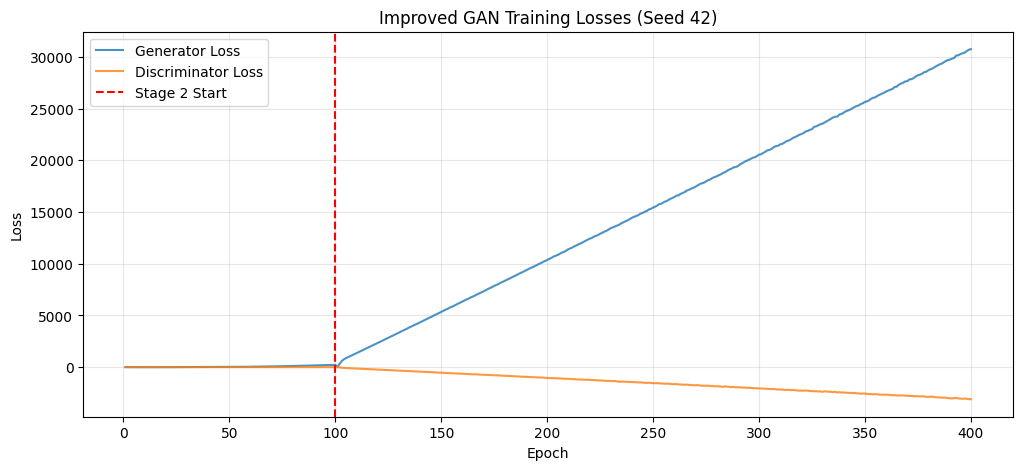

In [18]:
# Train improved GAN
print("="*60)
print("Training Improved GAN")
print("="*60)

generator, g_losses, d_losses = train_improved_gan(
    X_train, preprocessor,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE,
    stage1_epochs=STAGE1_EPOCHS,
    stage2_epochs=STAGE2_EPOCHS,
    lr_g=LR_G,
    lr_d=LR_D,
    n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP,
    lambda_moment=LAMBDA_MOMENT,
    lambda_corr=LAMBDA_CORR,
    lambda_special=LAMBDA_SPECIAL,
    lambda_per_feat=LAMBDA_PER_FEAT,
    temperature=TEMPERATURE,
    dropout=DROPOUT,
    instance_noise=INSTANCE_NOISE,
    seed=seed
)

# Plot training losses
plot_training_losses(
    g_losses, d_losses, STAGE1_EPOCHS,
    title=f"Improved GAN Training Losses (Seed {seed})",
    save_path=f'plots_improved/gan/losses_seed{seed}.png'
)


Generating synthetic samples...
Generated 26048 synthetic samples

Plotting feature distributions...


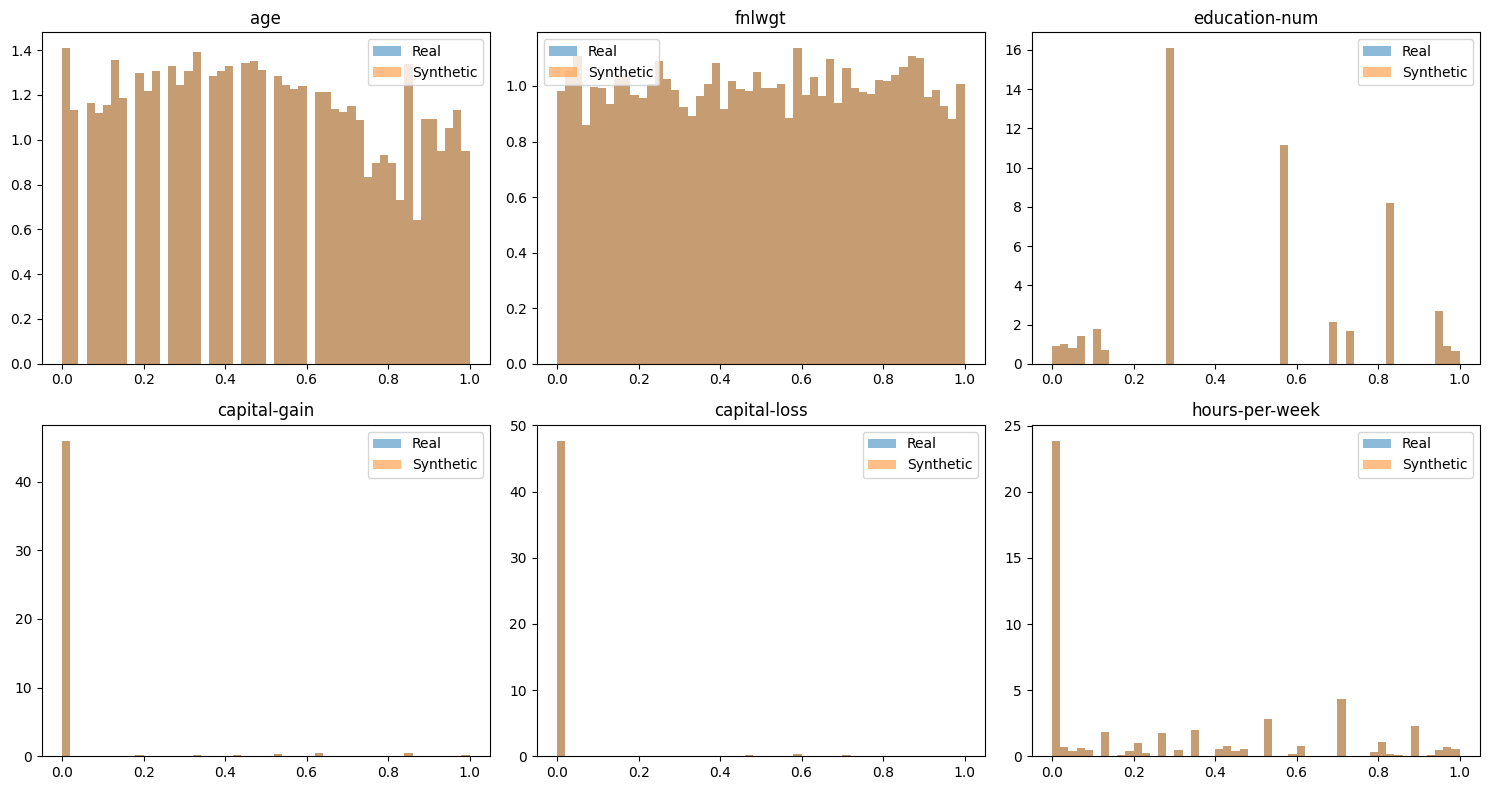


Plotting special value proportions...


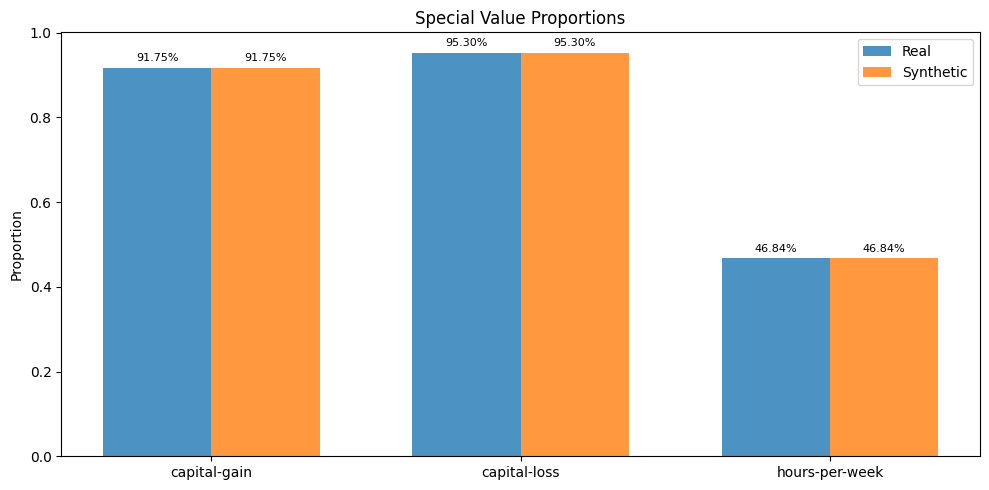

In [19]:
# Generate synthetic data with calibration
print("\nGenerating synthetic samples...")
n_samples = len(X_train)

# Generate without calibration first
synthetic_raw = generate_samples(generator, preprocessor, n_samples, LATENT_DIM)

# Generate synthetic labels (random)
synthetic_labels = np.random.choice([0, 1], size=n_samples, 
                                    p=[1 - y_train.mean(), y_train.mean()])

# Apply calibration
feature_structure = preprocessor.get_feature_structure()
synthetic_calibrated = full_calibration(synthetic_raw, X_train, feature_structure)

print(f"Generated {n_samples} synthetic samples")

# Plot comparisons
print("\nPlotting feature distributions...")
plot_feature_distributions(
    X_train, synthetic_calibrated, preprocessor,
    save_path=f'plots_improved/gan/features_seed{seed}.png'
)

print("\nPlotting special value proportions...")
plot_special_value_proportions(
    X_train, synthetic_calibrated, preprocessor,
    save_path=f'plots_improved/gan/special_values_seed{seed}.png'
)

In [20]:
# Compute metrics
print("\nComputing metrics...")

# Detection metric (with and without calibration)
print("\n--- Without Calibration ---")
detection_auc_raw, detection_std_raw = compute_detection_metric(X_train, synthetic_raw, seed=seed)
print(f"Detection AUC (raw): {detection_auc_raw:.4f} (+/- {detection_std_raw:.4f})")

print("\n--- With Calibration ---")
detection_auc, detection_std = compute_detection_metric(X_train, synthetic_calibrated, seed=seed)
print(f"Detection AUC (calibrated): {detection_auc:.4f} (+/- {detection_std:.4f})")

# Efficacy metric
efficacy_ratio, auc_real, auc_synth = compute_efficacy_metric(
    X_train, y_train, synthetic_calibrated, synthetic_labels, X_test, y_test, seed=seed
)

print(f"\nEfficacy Ratio: {efficacy_ratio:.4f}")
print(f"  - AUC (Real): {auc_real:.4f}")
print(f"  - AUC (Synthetic): {auc_synth:.4f}")

print(f"\n{'='*60}")
print(f"IMPROVED GAN RESULTS (Seed {seed}):")
print(f"{'='*60}")
print(f"Detection AUC: {detection_auc:.4f} (target: < 0.70, ideal: 0.50)")
print(f"Efficacy Ratio: {efficacy_ratio:.4f} (target: > 0.85, ideal: 1.00)")
print(f"{'='*60}")


Computing metrics...

--- Without Calibration ---
Detection AUC (raw): 1.0000 (+/- 0.0000)

--- With Calibration ---
Detection AUC (calibrated): 0.9704 (+/- 0.0012)

Efficacy Ratio: 0.5426
  - AUC (Real): 0.9071
  - AUC (Synthetic): 0.4921

IMPROVED GAN RESULTS (Seed 42):
Detection AUC: 0.9704 (target: < 0.70, ideal: 0.50)
Efficacy Ratio: 0.5426 (target: > 0.85, ideal: 1.00)


### Train Improved Conditional GAN (cGAN)

In [ ]:
# Train improved cGAN
print("="*60)
print("Training Improved cGAN")
print("="*60)

cgan_generator, cgan_g_losses, cgan_d_losses = train_improved_cgan(
    X_train, y_train, preprocessor,
    latent_dim=LATENT_DIM,
    hidden_dim=HIDDEN_DIM,
    batch_size=BATCH_SIZE,
    stage1_epochs=STAGE1_EPOCHS,
    stage2_epochs=STAGE2_EPOCHS,
    lr_g=LR_G,
    lr_d=LR_D,
    n_critic=N_CRITIC,
    lambda_gp=LAMBDA_GP,
    lambda_moment=LAMBDA_MOMENT,
    lambda_corr=LAMBDA_CORR,
    lambda_special=LAMBDA_SPECIAL,
    lambda_per_feat=LAMBDA_PER_FEAT,
    temperature=TEMPERATURE,
    dropout=DROPOUT,
    instance_noise=INSTANCE_NOISE,
    seed=seed
)

# Plot training losses
plot_training_losses(
    cgan_g_losses, cgan_d_losses, STAGE1_EPOCHS,
    title=f"Improved cGAN Training Losses (Seed {seed})",
    save_path=f'plots_improved/cgan/losses_seed{seed}.png'
)

Training Improved cGAN
Stage 1: Marginal matching (100 epochs)
Stage 2: Full adversarial (300 epochs)
Data dimension: 69, Num classes: 2


Training Improved cGAN:  12%|█▎        | 50/400 [02:16<16:00,  2.74s/it]

Epoch 50/400 (Stage 1): G_loss=7.4858, D_loss=0.0000


Training Improved cGAN:  25%|██▌       | 100/400 [04:32<13:32,  2.71s/it]

Epoch 100/400 (Stage 1): G_loss=56.6470, D_loss=0.0000


Training Improved cGAN:  38%|███▊      | 150/400 [08:15<18:33,  4.45s/it]

Epoch 150/400 (Stage 2): G_loss=5675.0602, D_loss=-567.8928


Training Improved cGAN:  50%|█████     | 200/400 [11:58<14:45,  4.43s/it]

Epoch 200/400 (Stage 2): G_loss=10935.3414, D_loss=-1096.2035


Training Improved cGAN:  62%|██████▎   | 250/400 [15:42<11:14,  4.50s/it]

Epoch 250/400 (Stage 2): G_loss=16230.5936, D_loss=-1631.3949


Training Improved cGAN:  74%|███████▎  | 294/400 [19:04<06:52,  3.89s/it]


KeyboardInterrupt: 

: 

In [ ]:
# Generate synthetic data from cGAN
print("\nGenerating synthetic samples from cGAN...")

# Sample labels uniformly from training distribution
cgan_synthetic_labels = np.random.choice([0, 1], size=n_samples, 
                                          p=[1 - y_train.mean(), y_train.mean()])

# Generate with conditioning
cgan_synthetic_raw = generate_samples(cgan_generator, preprocessor, n_samples, 
                                       LATENT_DIM, labels=cgan_synthetic_labels)

# Apply calibration
cgan_synthetic_calibrated = full_calibration(cgan_synthetic_raw, X_train, feature_structure)

print(f"Generated {n_samples} synthetic samples")

# Plot comparisons
print("\nPlotting feature distributions...")
plot_feature_distributions(
    X_train, cgan_synthetic_calibrated, preprocessor,
    save_path=f'plots_improved/cgan/features_seed{seed}.png'
)

print("\nPlotting special value proportions...")
plot_special_value_proportions(
    X_train, cgan_synthetic_calibrated, preprocessor,
    save_path=f'plots_improved/cgan/special_values_seed{seed}.png'
)

In [ ]:
# Compute cGAN metrics
print("\nComputing cGAN metrics...")

# Detection metric
print("\n--- Without Calibration ---")
cgan_detection_auc_raw, cgan_detection_std_raw = compute_detection_metric(X_train, cgan_synthetic_raw, seed=seed)
print(f"Detection AUC (raw): {cgan_detection_auc_raw:.4f} (+/- {cgan_detection_std_raw:.4f})")

print("\n--- With Calibration ---")
cgan_detection_auc, cgan_detection_std = compute_detection_metric(X_train, cgan_synthetic_calibrated, seed=seed)
print(f"Detection AUC (calibrated): {cgan_detection_auc:.4f} (+/- {cgan_detection_std:.4f})")

# Efficacy metric
cgan_efficacy_ratio, cgan_auc_real, cgan_auc_synth = compute_efficacy_metric(
    X_train, y_train, cgan_synthetic_calibrated, cgan_synthetic_labels, X_test, y_test, seed=seed
)

print(f"\nEfficacy Ratio: {cgan_efficacy_ratio:.4f}")
print(f"  - AUC (Real): {cgan_auc_real:.4f}")
print(f"  - AUC (Synthetic): {cgan_auc_synth:.4f}")

print(f"\n{'='*60}")
print(f"IMPROVED cGAN RESULTS (Seed {seed}):")
print(f"{'='*60}")
print(f"Detection AUC: {cgan_detection_auc:.4f} (target: < 0.70, ideal: 0.50)")
print(f"Efficacy Ratio: {cgan_efficacy_ratio:.4f} (target: > 0.85, ideal: 1.00)")
print(f"{'='*60}")

## 11. Final Comparison

In [ ]:
# Final comparison summary
print("="*70)
print("FINAL COMPARISON: IMPROVED GAN vs IMPROVED cGAN")
print("="*70)

comparison_data = {
    'Model': ['Improved GAN', 'Improved cGAN', 'Baseline GAN (original)', 'Baseline cGAN (original)'],
    'Detection AUC': [detection_auc, cgan_detection_auc, 0.998, 0.998],
    'Efficacy Ratio': [efficacy_ratio, cgan_efficacy_ratio, 0.99, 0.99],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*70)
print("IMPROVEMENT SUMMARY")
print("="*70)
print(f"GAN Detection AUC: {0.998:.4f} -> {detection_auc:.4f} (change: {detection_auc - 0.998:+.4f})")
print(f"GAN Efficacy:      {0.99:.4f} -> {efficacy_ratio:.4f} (change: {efficacy_ratio - 0.99:+.4f})")
print(f"cGAN Detection AUC: {0.998:.4f} -> {cgan_detection_auc:.4f} (change: {cgan_detection_auc - 0.998:+.4f})")
print(f"cGAN Efficacy:      {0.99:.4f} -> {cgan_efficacy_ratio:.4f} (change: {cgan_efficacy_ratio - 0.99:+.4f})")
print("="*70)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

models = ['Improved\nGAN', 'Improved\ncGAN', 'Baseline\nGAN', 'Baseline\ncGAN']
detection_vals = [detection_auc, cgan_detection_auc, 0.998, 0.998]
efficacy_vals = [efficacy_ratio, cgan_efficacy_ratio, 0.99, 0.99]
colors = ['steelblue', 'coral', 'lightblue', 'lightsalmon']

# Detection AUC (lower is better)
axes[0].bar(models, detection_vals, color=colors)
axes[0].axhline(y=0.5, color='green', linestyle='--', label='Ideal (0.5)')
axes[0].axhline(y=0.7, color='orange', linestyle='--', label='Target (<0.7)')
axes[0].set_ylabel('Detection AUC')
axes[0].set_title('Detection AUC (Lower is Better)')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Efficacy (higher is better)
axes[1].bar(models, efficacy_vals, color=colors)
axes[1].axhline(y=1.0, color='green', linestyle='--', label='Ideal (1.0)')
axes[1].axhline(y=0.85, color='orange', linestyle='--', label='Target (>0.85)')
axes[1].set_ylabel('Efficacy Ratio')
axes[1].set_title('Efficacy Ratio (Higher is Better)')
axes[1].legend()
axes[1].set_ylim(0, 1.2)

plt.tight_layout()
plt.savefig('plots_improved/comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()